In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as dataloader
import torch.nn as nn

In [ ]:
transformation=transforms.Compose([transforms.ToTensor()])

In [ ]:
train_dataset=torchvision.datasets.MNIST(root="./data",train=True,download=True,transform=transformation)
val_dataset=torchvision.datasets.MNIST(root="./data",train=False,download=True,transform=transformation)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.95MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.16MB/s]


In [ ]:
trainloader=dataloader.DataLoader(train_dataset,batch_size=64,shuffle=True)
valLoader=dataloader.DataLoader(val_dataset,batch_size=64,shuffle=False)


In [ ]:
num_classes=10
batch_size=64
num_channels=1
img_size=28
patch_size=7
no_of_patches=(img_size//patch_size)**2
embedding_dim=64
attention_heads=4
transformer_block=4
learning_rate=0.001
mlp_hiddlen_nodes=128
epocs=5

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embed=nn.Conv2d(num_channels,embedding_dim,kernel_size=patch_size,stride=patch_size)

  def forward(self,x):
    x=self.patch_embed(x)
    x=x.flatten(2)
    x=x.transpose(1,2)
    return x

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1=nn.LayerNorm(embedding_dim)
    self.layer_norm2=nn.LayerNorm(embedding_dim)
    self.multi_head_attention=nn.MultiheadAttention(embedding_dim,attention_heads,batch_first=True)
    self.mlp=nn.Sequential(
        nn.Linear(embedding_dim,mlp_hiddlen_nodes),
        nn.GELU(),
        nn.Linear(mlp_hiddlen_nodes,embedding_dim)
    )

  def forward(self,x):
    residual=x
    x=self.layer_norm1(x)
    x = self.multi_head_attention(x, x, x)[0]
    x = residual + x

    residual = x
    x = self.layer_norm2(x)
    x = self.mlp(x)
    x = residual + x
    return x

In [ ]:
class Mlp_Head(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm=nn.LayerNorm(embedding_dim)
    self.mlp_head=nn.Linear(embedding_dim,num_classes)

  def forward(self,x):
    x=self.layer_norm(x)
    x=x[:,0]
    x=self.mlp_head(x)
    return x

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding=PatchEmbedding()
    self.cls_token=nn.Parameter(torch.randn(1,1,embedding_dim))
    self.pos_embedding=nn.Parameter(torch.randn(1,no_of_patches+1,embedding_dim))
    self.transformer=nn.Sequential(*[TransformerEncoder() for _ in range(transformer_block)])
    self.mlp_head=Mlp_Head()

  def forward(self,x):
    x=self.patch_embedding(x)
    cls_token=self.cls_token.expand(x.shape[0],-1,-1)
    x=torch.cat((cls_token,x),dim=1)
    x=x+self.pos_embedding
    x=self.transformer(x)
    x=self.mlp_head(x)
    return x

In [16]:
torch.save(model.state_dict(), 'vision_transformer_mnist.pth')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=VisionTransformer().to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion=nn.CrossEntropyLoss()

In [ ]:
for epoch in range(epocs):
  model.train()
  total_loss=0
  correct_epoch=0
  total_epoch=0

  for images,labels in trainloader:
    images=images.to(device)
    labels=labels.to(device)
    optimizer.zero_grad()
    outputs=model(images)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()
    _,predicted=torch.max(outputs.data,1)
    total_epoch+=labels.size(0)
    correct_epoch+=(predicted==labels).sum().item()
  print(f'Epoch {epoch+1}/{epocs}, Loss: {total_loss/len(trainloader):.4f}, Accuracy: {100*correct_epoch/total_epoch:.2f}%')

Epoch 1/5, Loss: 0.3426, Accuracy: 89.25%
Epoch 2/5, Loss: 0.1191, Accuracy: 96.40%
Epoch 3/5, Loss: 0.0890, Accuracy: 97.23%
Epoch 4/5, Loss: 0.0710, Accuracy: 97.78%
Epoch 5/5, Loss: 0.0630, Accuracy: 98.00%


In [ ]:
model.eval()
with torch.no_grad():
    correct_val = 0
    total_val = 0
    for images, labels in valLoader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()

    print(f'Validation Accuracy: {100 * correct_val / total_val:.2f}%')

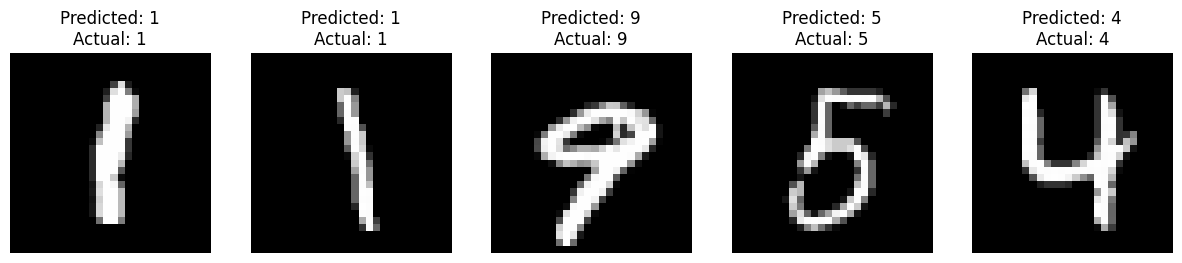

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels from the validation loader
dataiter = iter(valLoader)
images, labels = next(dataiter)

# Select a few random images from the batch
num_images_to_show = 5
random_indices = np.random.choice(batch_size, num_images_to_show, replace=False)
random_images = images[random_indices]
random_labels = labels[random_indices]

# Move images to the device
random_images = random_images.to(device)

# Get predictions from the model
model.eval()
with torch.no_grad():
    outputs = model(random_images)
    _, predicted = torch.max(outputs.data, 1)

# Display the images and predictions
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 5))
for i in range(num_images_to_show):
    axes[i].imshow(random_images[i].cpu().squeeze(), cmap='gray')
    axes[i].set_title(f'Predicted: {predicted[i].item()}\nActual: {random_labels[i].item()}')
    axes[i].axis('off')
plt.show()